
# ENEM 2023 — 02 · Exploração Bivariada & Figuras (Matplotlib)

Objetivo: produzir **gráficos prontos** para o relatório, usando **matplotlib** (sem seaborn), um gráfico por célula.  
As imagens serão salvas em `reports/figures/`.

> Dica: rode **Kernel → Restart & Run All** para gerar tudo de forma reprodutível.


In [1]:

# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Caminhos
PARQUET_PATH = Path("../data/interim/enem_2023.parquet").resolve()  # ajuste se necessário
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("Parquet:", PARQUET_PATH)
print("Figuras em:", FIG_DIR)
df = pd.read_parquet(PARQUET_PATH)
print("Shape:", df.shape)


Parquet: /Users/gabrielfontineli/Documents/study/enem-data-exploration/data/interim/enem_2023.parquet
Figuras em: ../reports/figures
Shape: (2166843, 20)



## 1) Boxplot — `NOTA_MEDIA_5` por `TP_ESCOLA`

Comparação direta de distribuição entre tipos de escola.


<Figure size 600x400 with 0 Axes>

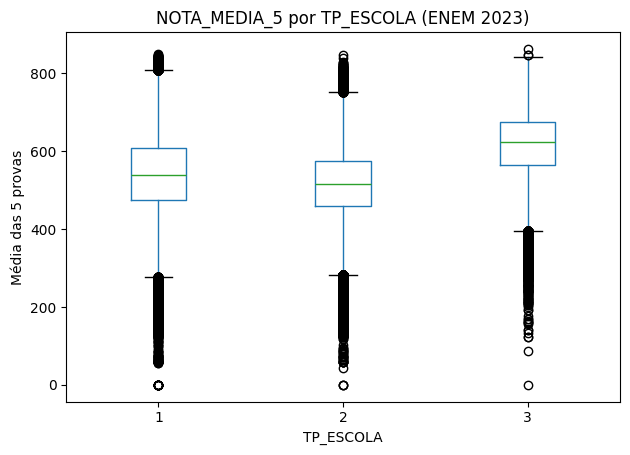

Salvo: ../reports/figures/boxplot_media5_por_tp_escola.png


In [2]:

if "TP_ESCOLA" in df.columns:
    plt.figure(figsize=(6,4))
    df.boxplot(column="NOTA_MEDIA_5", by="TP_ESCOLA", grid=False)
    plt.title("NOTA_MEDIA_5 por TP_ESCOLA (ENEM 2023)")
    plt.suptitle("")
    plt.xlabel("TP_ESCOLA")
    plt.ylabel("Média das 5 provas")
    plt.tight_layout()
    out = FIG_DIR / "boxplot_media5_por_tp_escola.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    print("Salvo:", out)
else:
    print("Coluna TP_ESCOLA não encontrada.")



## 2) Tendência — Renda (Q006 ordinal) × `NOTA_MEDIA_5`

Mapeamos `A..Z → 1..26` só para enxergar a tendência geral. Depois é possível substituir por rótulos oficiais.


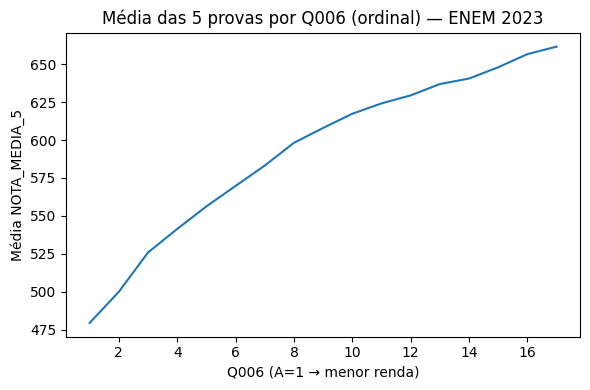

Salvo: ../reports/figures/linha_media5_por_q006_ordinal.png
Tabela salva: ../reports/figures/tabela_media5_por_q006_ordinal.csv


In [4]:

if "Q006" in df.columns:
    ord_map = {chr(i): i-64 for i in range(65,91)}  # A..Z -> 1..26
    q = df["Q006"].map(ord_map)
    tmp = pd.DataFrame({"Q006_ord": q, "NOTA_MEDIA_5": df["NOTA_MEDIA_5"]}).dropna()
    trend = tmp.groupby("Q006_ord")["NOTA_MEDIA_5"].mean().reset_index().sort_values("Q006_ord")
    plt.figure(figsize=(6,4))
    plt.plot(trend["Q006_ord"], trend["NOTA_MEDIA_5"])
    plt.title("Média das 5 provas por Q006 (ordinal) — ENEM 2023")
    plt.xlabel("Q006 (A=1 → menor renda)")
    plt.ylabel("Média NOTA_MEDIA_5")
    plt.tight_layout()
    out = FIG_DIR / "linha_media5_por_q006_ordinal.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    print("Salvo:", out)
    # Exporta a tabela para eventual uso no relatório
    csv_out = FIG_DIR / "tabela_media5_por_q006_ordinal.csv"
    trend.to_csv(csv_out, index=False)
    print("Tabela salva:", csv_out)
else:
    print("Coluna Q006 não encontrada.")



## 3) Barras — Média por UF (`SG_UF_RESIDENCIA`)

Média da `NOTA_MEDIA_5` por estado (ordem decrescente).


In [3]:

if "SG_UF_RESIDENCIA" in df.columns:
    m = df.groupby("SG_UF_RESIDENCIA")["NOTA_MEDIA_5"].mean().sort_values(ascending=False)
    plt.figure(figsize=(7,5))
    m.plot(kind="bar")
    plt.title("Média da NOTA_MEDIA_5 por UF — ENEM 2023")
    plt.xlabel("UF")
    plt.ylabel("Média NOTA_MEDIA_5")
    plt.tight_layout()
    out = FIG_DIR / "barras_media5_por_uf.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    print("Salvo:", out)
    csv_out = FIG_DIR / "tabela_media5_por_uf.csv"
    m.reset_index().to_csv(csv_out, index=False)
    print("Tabela salva:", csv_out)
else:
    print("Coluna SG_UF_RESIDENCIA não encontrada.")


Coluna SG_UF_RESIDENCIA não encontrada.



## 4) Heatmap simples — Correlação entre notas

Matriz de correlação (Pearson) entre as cinco notas e a média (imshow).


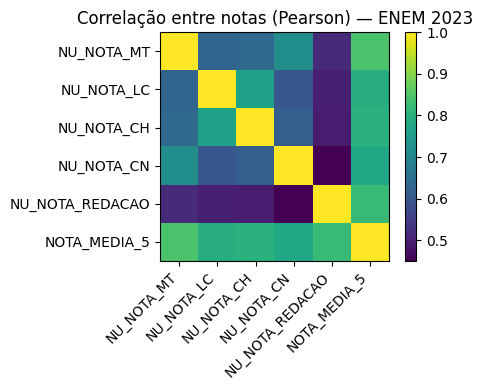

Salvo: ../reports/figures/heatmap_correlacao_notas.png
Tabela salva: ../reports/figures/tabela_correlacao_notas.csv


In [6]:

nota_cols = [c for c in ["NU_NOTA_MT","NU_NOTA_LC","NU_NOTA_CH","NU_NOTA_CN","NU_NOTA_REDACAO","NOTA_MEDIA_5"] if c in df.columns]
if len(nota_cols) >= 2:
    corr = df[nota_cols].corr(numeric_only=True)
    plt.figure(figsize=(5,4))
    plt.imshow(corr, interpolation="nearest")
    plt.title("Correlação entre notas (Pearson) — ENEM 2023")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar()
    plt.tight_layout()
    out = FIG_DIR / "heatmap_correlacao_notas.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    print("Salvo:", out)
    csv_out = FIG_DIR / "tabela_correlacao_notas.csv"
    corr.to_csv(csv_out)
    print("Tabela salva:", csv_out)
else:
    print("Notas insuficientes para correlação.")



## 5) Dispersão — `NU_NOTA_MT` × `NU_NOTA_CN`

Gráfico de dispersão com `alpha` para reduzir sobreposição.


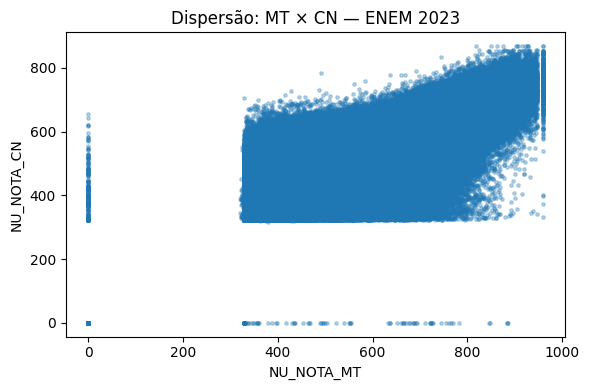

Salvo: ../reports/figures/scatter_mt_vs_cn.png


In [7]:

if set(["NU_NOTA_MT","NU_NOTA_CN"]).issubset(df.columns):
    x = df["NU_NOTA_MT"].astype(float)
    y = df["NU_NOTA_CN"].astype(float)
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, s=6, alpha=0.3)
    plt.title("Dispersão: MT × CN — ENEM 2023")
    plt.xlabel("NU_NOTA_MT")
    plt.ylabel("NU_NOTA_CN")
    plt.tight_layout()
    out = FIG_DIR / "scatter_mt_vs_cn.png"
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    print("Salvo:", out)
else:
    print("Colunas de notas MT/CN não encontradas.")



## 6) Exportar tabelas resumidas (para o relatório)

Gera CSVs de resumos úteis (por escola e por UF).


In [8]:

# Média por tipo de escola
if "TP_ESCOLA" in df.columns:
    t1 = df.groupby("TP_ESCOLA")["NOTA_MEDIA_5"].agg(["count","mean","std"]).round(2)
    out = FIG_DIR / "tabela_media5_por_tp_escola.csv"
    t1.reset_index().to_csv(out, index=False)
    print("Tabela salva:", out)

# Média por UF
if "SG_UF_RESIDENCIA" in df.columns:
    t2 = df.groupby("SG_UF_RESIDENCIA")["NOTA_MEDIA_5"].agg(["count","mean","std"]).round(2)
    out = FIG_DIR / "tabela_media5_por_uf_stats.csv"
    t2.reset_index().to_csv(out, index=False)
    print("Tabela salva:", out)


Tabela salva: ../reports/figures/tabela_media5_por_tp_escola.csv
